## Starter Medical Imaging Tutorial

This notebook is based on this [notebook](https://github.com/fastai/fastai/blob/master/nbs/61_tutorial.medical_imaging.ipynb) but uses additions from the `fmi` library.

To learn more about medical imaging and using fastai with medical imaging you can view my [blog](https://asvcode.github.io/MedicalImaging/)

**Tutorial Breakdown**

- Imports
 - system info
- Explore
 - getting the data
 - dicom metadata
 - dicom image info
 - what is PII?
 - from_dicoms
- Pre Processing
  - splitting the data
  - distribution of classes
  - create DataBlock
- Train
  - create your own Callback
  - timm
- Examine
  - results evaluation
  - confusion matrix
  - sensitivity, specificity, PPV, NPV, accuracy
- Under the Hood - Model Interpretability
 - generating bounding boxes from class activation maps

In [1]:
import pydicom,kornia,skimage
from fastai.vision.all import *
from fastai.medical.imaging import *
from torchvision.utils import save_image
import seaborn as sns

from fmi.pipeline import *
from fmi.explore import *
from fmi.preprocessing import *
from fmi.examine import *
from fmi.train import *
from sklearn.model_selection import train_test_split

import timm
matplotlib.rcParams['image.cmap'] = 'viridis'

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

`system_info` conveniently lists the current `fastai`, `fastcore`versions as well as `cuda`, `pydicom` and `kornia` versions

In [3]:
system_info()

fastai Version: 2.4
fastcore Version: 1.3.20
python Version: 3.8.10 (default, May 19 2021, 13:12:57) [MSC v.1916 64 bit (AMD64)]
torchvision: 0.8.2+cu110
torch version: 1.7.1+cu110

Cuda: True
Cuda Version: 11.0
GPU: NVIDIA GeForce RTX 3070 Laptop GPU

pydicom Version: 2.1.2
kornia Version: 0.2.0


## Explore

### Getting The Data

The data consists of 250 dicom images from the [SIIM-ACR Pneumothorax Segmentation dataset](https://doi.org/10.1007/s10278-019-00299-9) which consists of chest X-rays with and without pneumothorax. 

In [4]:
pneu = untar_data(URLs.SIIM_SMALL)
p_items = get_dicom_files(f'{pneu}/train')
p_items

(#250) [Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000000.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000002.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000005.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000006.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000007.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000008.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000009.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000011.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000012.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000014.dcm')...]

In [5]:
df = pd.read_csv(f'{pneu}/labels.csv')
df[:5]

file            label
0  train/No Pneumothorax/000000.dcm  No Pneumothorax
1     train/Pneumothorax/000001.dcm     Pneumothorax
2  train/No Pneumothorax/000002.dcm  No Pneumothorax
3     train/Pneumothorax/000003.dcm     Pneumothorax
4     train/Pneumothorax/000004.dcm     Pneumothorax

#### Dicom metadata

Dicom metadata contains a wealth of information like the example below.

In [6]:
p_items[0].dcmread()

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

#### Dicom image info

However sometimes it is better to get more targeted information from the metadata.

`get_image_info` provides image specific information such as the Modality, Photometric Interpretation, Pixel Spacing, SliceThickness, Bits Allocated, RescaleIntercept and RescaleSlope.  This information is important when modelling the data.  Note that in this dataset the dicom images do not have any `Rescale Intercept` or `Rescale Slope`

In [7]:
get_image_info(p_items[0])

(0008, 0060) Modality                            CS: 'CR'
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0030) Pixel Spacing                       DS: [0.168, 0.168]
No SliceThickness
(0028, 0100) Bits Allocated                      US: 8
(0028, 0101) Bits Stored                         US: 8
(0028, 0103) Pixel Representation                US: 0
No Pixel Padding Value
No Rescale Intercept
No Rescale Slope


#### What about PII?

**PII** or **Personally Identifiable Information** refers to information that can be used to distinguish or trace an individual's identity, either alone or when combined with other personal or identifying information that is linked or linkable to a specific individual.

When dealing with medical based datasets it is important to know if there are any patient identifiable identifiers within the metadata.  This information if present is important to consider because it may reveal additional information as well as potential bias. Understanding what identifiable information is contained within the metadata is important in creating a fair non-biased model.

`get_pii` conveniently lists this information as well as looking for the `Image Comments` tag within the metadata that may contain useful information.

It is also sometimes useful to know if there is any information about with de-identification information is available in the dicom meta-data.

In [8]:
get_pii(p_items[0])

(0010, 0010) Patient's Name                      PN: '16d7f894-55d7-4d95-8957-d18987f0e981'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '62'
No Image Comments
No De-Identification method
No De-identification Method Code Sequence


#### from_dicoms

`fastai` has a handy method `from_dicoms` that can convert dicom metadata into a dataframe. By default from_dicoms returns additional stats such as minimal pixel value, maximum pixel value, mean pixel value, image standard deviation and pct_in_window value depending on the specified window value. These stats are returned at the end of the dataframe.

I successfully submitted a `PR` that allows you to toggle the creation of additional stats on or off.  Note that if you have a really big dataset having this option as on could significantly increase the compute time.

In [9]:
%%time
patient_df = pd.DataFrame.from_dicoms(p_items, window=dicom_windows.lungs, px_summ=True)
patient_df[:5].T.tail(5)

Wall time: 7.45 s


0           1           2           3           4
img_min                  0           0           0           0           0
img_max                254         250         246         255         250
img_mean        160.398039  114.524713  132.218334  153.405355  166.198407
img_std          53.854885   70.752315   73.023531   59.543063   50.008985
img_pct_window    0.358613     0.62032    0.561823    0.359524    0.345166

In [10]:
%%time
patient_df = pd.DataFrame.from_dicoms(p_items, window=dicom_windows.lungs, px_summ=False)
patient_df[:5].T.tail(5)

Wall time: 1.52 s


0  \
LossyImageCompression                                                                             01   
LossyImageCompressionMethod                                                              ISO_10918_1   
fname                        C:\Users\avird\.fastai\data\siim_small\train\No Pneumothorax\000000.dcm   
MultiPixelSpacing                                                                                  1   
PixelSpacing1                                                                                  0.168   

                                                                                                   1  \
LossyImageCompression                                                                             01   
LossyImageCompressionMethod                                                              ISO_10918_1   
fname                        C:\Users\avird\.fastai\data\siim_small\train\No Pneumothorax\000002.dcm   
MultiPixelSpacing                                                                                  1   
PixelSpacing1                                                                                  0.143   

                                                                                                   2  \
LossyImageCompression                                                                             01   
LossyImageCompressionMethod                                                              ISO_10918_1   
fname                        C:\Users\avird\.fastai\data\siim_small\train\No Pneumothorax\000005.dcm   
MultiPixelSpacing                                                                                  1   
PixelSpacing1                                                                                  0.143   

                                                                                                   3  \
LossyImageCompression                                                                             01   
LossyImageCompressionMethod                                                              ISO_10918_1   
fname                        C:\Users\avird\.fastai\data\siim_small\train\No Pneumothorax\000006.dcm   
MultiPixelSpacing                                                                                  1   
PixelSpacing1                                                                                  0.171   

                                                                                                   4  
LossyImageCompression                                                                             01  
LossyImageCompressionMethod                                                              ISO_10918_1  
fname                        C:\Users\avird\.fastai\data\siim_small\train\No Pneumothorax\000007.dcm  
MultiPixelSpacing                                                                                  1  
PixelSpacing1                                                                                  0.171

Get some basic stats:

Male/Female distribution

In [11]:
patient_df['PatientSex'].value_counts()

M    125
F    125
Name: PatientSex, dtype: int64

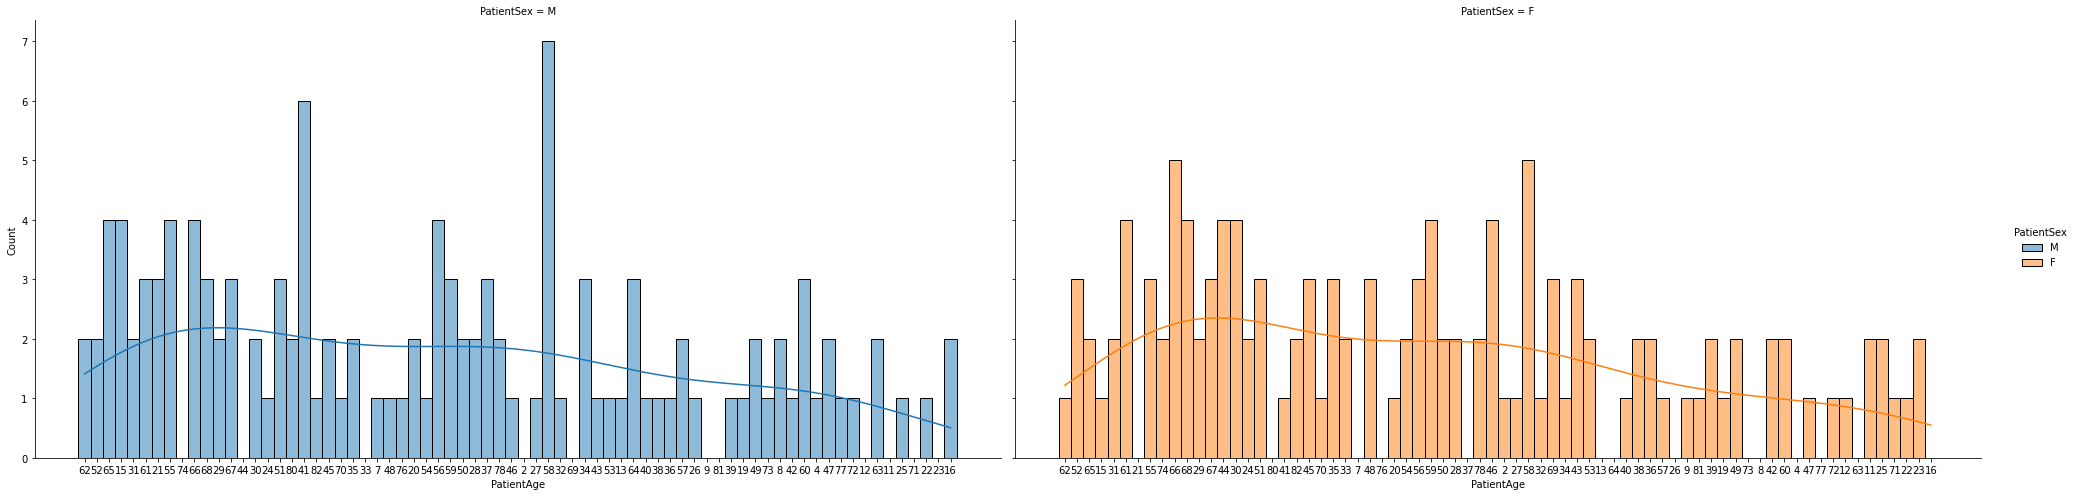

In [12]:
sns.displot(data=patient_df, x="PatientAge", kde=True, col="PatientSex", hue='PatientSex', height=7, aspect=2);

## PreProcessing

### Splitting The Data

It is common practice to split the dataset into `train` and `valid`, for example `RandomSplitter` splits the data with a 80:20 split.  However it is also important to ensure that the same patient is not present in both the train and valid splits

In [13]:
trn,val = RandomSplitter(valid_pct=0.2, seed=7)(p_items)

You can now see the indicies of each image in the `train` and `valid` sets

In [14]:
trn, val

((#200) [33,65,231,167,74,127,184,89,122,79...],
 (#50) [115,233,139,163,161,177,57,21,34,99...])

The `SIIM_SMALL` only contains 250 images and you can easily check if duplicates will exist when splitting the data by using `check_duplicates` and specifying a `seed` value.

Train: 200 
 Original Validation: 50 
 Updated Validation: 50


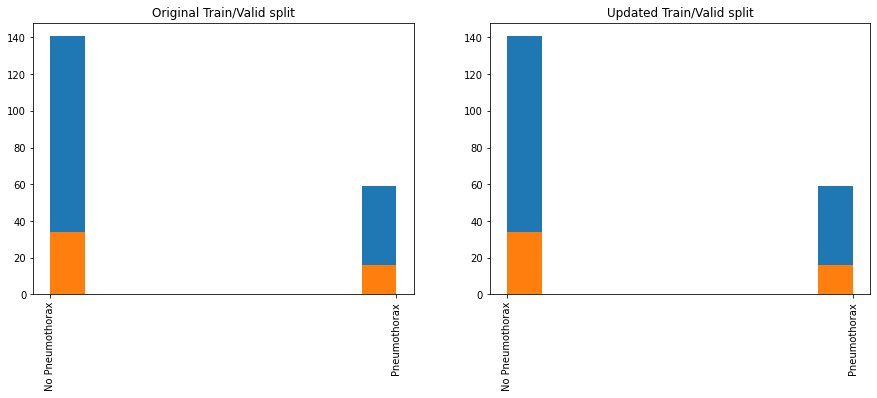

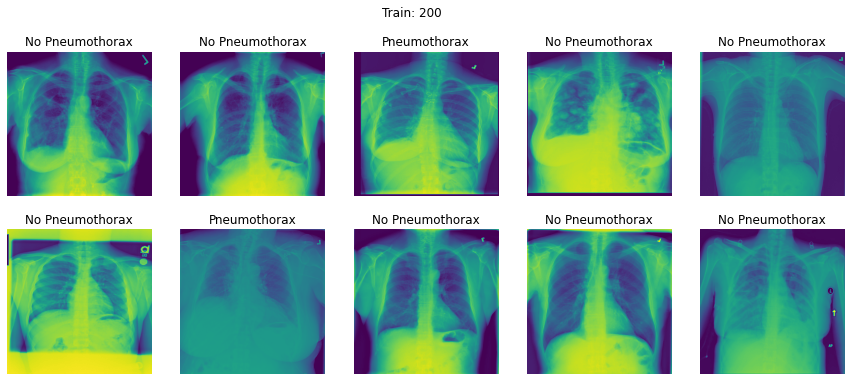

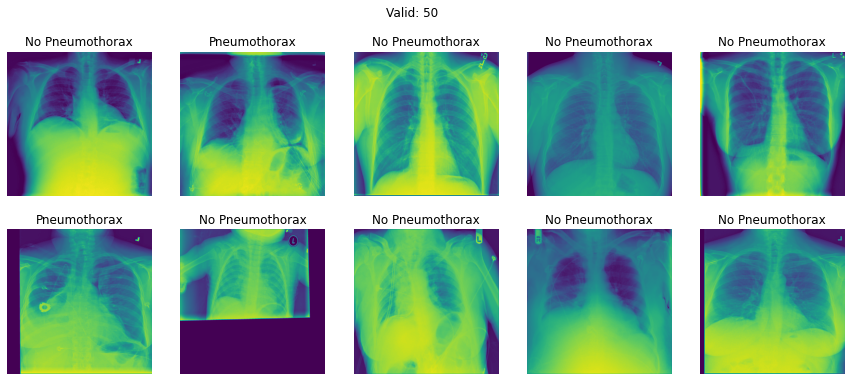

In [15]:
check_duplicate(p_items, valid_pct=0.2, seed=7)

`check_duplicates` displays the number of train and valid images and if there are duplicates it will also display the updated valid count with the duplicates removed from the valid set.  It also displays images from the train and valid sets

The dataset as is does not have any duplicate images and hence the reason why the updated valid count is the same as the original valid count of 50.

**What happens when there is/are duplicates in the train and valid sets?**

To see what happens I have another dataset that contains duplicate images

In [16]:
duplicate_ds = get_dicom_files(f'{pneu}/sm')

Train: 211 
 Original Validation: 52 
 Updated Validation: 48


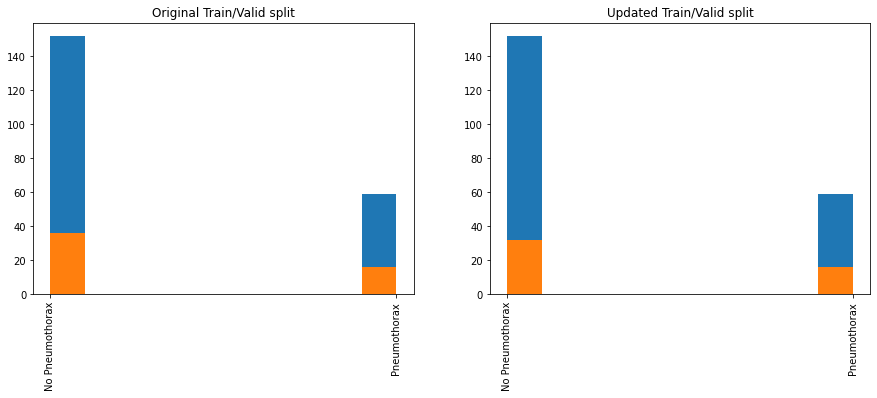

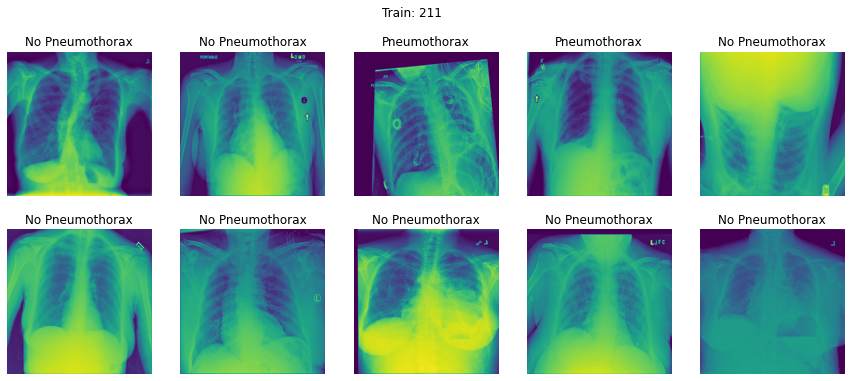

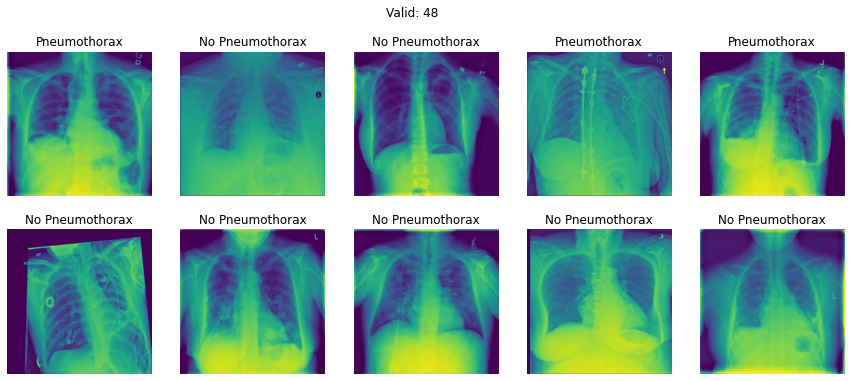

In [17]:
check_duplicate(duplicate_ds, valid_pct=0.2, seed=7)

In this case the original split had 211 images in the train set and 52 images in the validation set.  `check_duplicates` was able to find 4 duplicates in the validation set and removes them from there so the updated validation count is now 48.  However we now know that there are no duplicate patients in the train or validation sets.

### Distribution of Classes

Another import aspect of pre-processing is looking at the distribution of classes within the dataset.

In [18]:
df['label'].value_counts()

No Pneumothorax    175
Pneumothorax        75
Name: label, dtype: int64

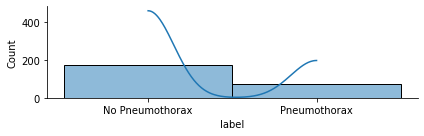

In [19]:
sns.displot(data=df, x="label", kde=True, height=2, aspect=3);

We can see from the distribution that the dataset is unbalanced towards the `No Pneumothorax` class.  To account for this we can use `WeightedDL`.

In order to see how this works we first need to create the DataBlock.

#### dicom_splitter

Earlier we used `check_duplicates` to see if there were any duplicate patients in the train and valid sets. `dicom_splitter` uses the same functionality to create out splitter and can be passed when creating the DataBlock.

In [20]:
splitter = dicom_splitter(p_items, valid_pct=0.2, seed=7)

#### Create The DataBlock

Specify the `item_tfms` and `batch_tfms` to your specifications

In [21]:
item_tfms = Resize(266)
batch_tfms = [RandomResizedCropGPU(226), *aug_transforms(do_flip=False, flip_vert=False, max_rotate=10.,
                                                         min_zoom=1., max_zoom=1.1, max_lighting=0.2, max_warp=0.1),
                                                         Normalize.from_stats(*imagenet_stats)]

In [22]:
set_seed(7)
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
                   get_x=lambda x:pneu/f"{x[0]}",
                   get_y=lambda x:x[1],
                   splitter=splitter,
                   item_tfms = item_tfms,
                   batch_tfms = batch_tfms)

Note using `num_workers` as 0 because I am using a windows machine although recent updates in `fastai` will automatically select this for you to prevent errors.

For reproducibilty I am using `set_seed`

In [23]:
set_seed(7)
dls = pneumothorax.dataloaders(df.values, bs=32, num_workers=0)

200 50


Using `dicom_splitter` in the DataBlock automatically prints out the size of the train and valid sets when creating the dataloaders.

Now to check the distribution of classes within the current dataloader over 10 batches:

In [24]:
for i in range(10):
    x,y = dls.one_batch()
    print(sum(y)/len(y))

tensor(0.3750, device='cuda:0')
tensor(0.3125, device='cuda:0')
tensor(0.2812, device='cuda:0')
tensor(0.3125, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(0.2188, device='cuda:0')
tensor(0.4062, device='cuda:0')
tensor(0.3125, device='cuda:0')
tensor(0.2188, device='cuda:0')
tensor(0.2188, device='cuda:0')


We can see that the distribution of classes with each batch is not 50:50 and more like 30:70.

We can use `WeighedDL` to help create batches where the classes are distributed 50:50.  The following is credited to this [thread](https://forums.fast.ai/t/issue-with-weighteddl/88125/2).

However to get the labels we first need to get the distribution of the labels in the train set.  We used `dicom_splitter` so we need to ensure that we have the right images and labels in the train set when we calculate the label weights.  `dicom_splitter` uses `dicomsplit` and we can use that here as well to get the images that will be used in the train set.

In [25]:
trn, new_val, val, train_L, val_L, new_val_o = dicomsplit(valid_pct=0.2, seed=7)(p_items)
train_L[-1]

(#200) [Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000044.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000093.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/Pneumothorax/000187.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000241.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000103.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000182.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/Pneumothorax/000042.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000123.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000176.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000110.dcm')...]

In [26]:
def get_lb(fn):
    fn = str(fn)
    lb = fn.split('\\')[-2]
    return lb

In [27]:
labels = [get_lb(item) for item in train_L[-1]]
Counter(labels)

Counter({'No Pneumothorax': 141, 'Pneumothorax': 59})

In [28]:
dset = pneumothorax.datasets(df.values)

200 50


In [29]:
count = Counter(labels)
wgts = [1/count[dset.vocab[label]] for img, label in dset.train]
len(wgts)

200

Delete the previous dataloader

In [30]:
del dls

And create a new one using `WeightedDL` and use the label weights generated prior.

In [31]:
set_seed(7)
dls = pneumothorax.dataloaders(df.values, bs=32, num_workers=0, dl_type=WeightedDL, wgts=wgts)

200 50


In [32]:
for i in range(10):
    x,y = dls.one_batch()
    print(sum(y)/len(y))

tensor(0.5000, device='cuda:0')
tensor(0.5312, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.4688, device='cuda:0')
tensor(0.5938, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.4375, device='cuda:0')
tensor(0.4688, device='cuda:0')
tensor(0.4375, device='cuda:0')
tensor(0.3438, device='cuda:0')


We can see that over 10 batches the distribution is more even.

View a batch

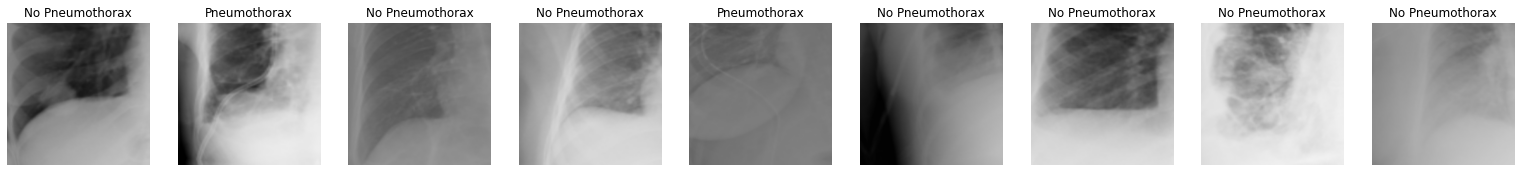

In [33]:
dls.show_batch(nrows=1)

### Training

**Creating your own Callback**

This section is still under development but I wanted to show how you can creat your own `Callback`

Here we create a simple callback that prints out the `epoch` and `iteration`.

In [34]:
class CreateCallback(Callback):
    def after_epoch(self, **kwargs):
        print(f'After EPOCH: {self.epoch} ITER: {self.train_iter}')

Note that in `fastai` there are other callbacks that are used:

**By Default** (unless you remove them):

**> TrainEvalCallback** - Callback that tracks the number of iterations done and properly sets training/eval mode

**> Recorder** - Callback that registers statistics (lr, loss and metrics) during training

**> ProgressCallback** - Callback to handle the display of progress bars

In this tutorial we will also use 2 other `Callbacks`:

- ReduceLROnPlateau - which is a `TrackerCallback` that reduces learning rate when a metric has stopped improving.
- GradientClip - which clips norm of gradients to prevents diverging
- ShowGraphCallback - displays a graph of training and validation loss

### Timm

The `fastai` library provides a number of models that can be used for training. However the `timm` [library](https://github.com/rwightman/pytorch-image-models) provides a plethora of cutting edge and old models that can be used.

For use of these models with `fastai` is credited to this [notebook](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/05_EfficientNet_and_Custom_Weights.ipynb)

To view the available models that are available from the `timm` library:

In [35]:
avail_models = timm.list_models(pretrained=True)
#avail_models

In this tutorial I am going to use `resnetblur50` which constructs a ResNet-50 model with blur anti-aliasing.

In [36]:
set_seed(7)
learn = timm_learner(dls, 
                    'resnetblur50' ,
                     pretrained=True,
                    loss_func=LabelSmoothingCrossEntropyFlat(), 
                    metrics=accuracy, 
                    cbs=[ShowGraphCallback(), ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=1),\
                         GradientClip, \
                         SaveModelCallback(monitor='accuracy',fname='siim_small_best',comp=np.greater, with_opt=True),\
                         CreateCallback()])

`fastai` has a handy feature that will display the whole training loop and show where each callback is called within the loop

In [37]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback, SaveModelCallback, ReduceLROnPlateau, ShowGraphCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - before_step    : [GradientClip]
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback, ShowGraphCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Rec

Looking at the training loop you can see that `CreateCallback` will be called during the `after_step` step because that is what was specified in the callback.

After EPOCH: 0 ITER: 6
Better model found at epoch 0 with accuracy value: 0.30000001192092896.


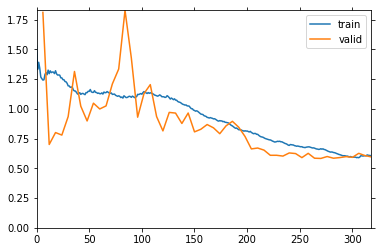

After EPOCH: 1 ITER: 12
Better model found at epoch 1 with accuracy value: 0.6000000238418579.
After EPOCH: 2 ITER: 18
Better model found at epoch 2 with accuracy value: 0.6600000262260437.
Epoch 2: reducing lr to 1.4429888844873704e-05
After EPOCH: 3 ITER: 24
Better model found at epoch 3 with accuracy value: 0.699999988079071.
Epoch 3: reducing lr to 2.2498100075188845e-05
After EPOCH: 4 ITER: 30
Epoch 4: reducing lr to 3.221706023927435e-05
After EPOCH: 5 ITER: 36
Epoch 5: reducing lr to 4.304296199207852e-05
After EPOCH: 6 ITER: 42
Epoch 6: reducing lr to 5.437005189221709e-05
After EPOCH: 7 ITER: 48
Epoch 7: reducing lr to 6.556452308243118e-05
After EPOCH: 8 ITER: 54
Epoch 8: reducing lr to 7.600000259466076e-05
After EPOCH: 9 ITER: 60
Epoch 9: reducing lr to 8.509258179773409e-05
After EPOCH: 10 ITER: 66
Epoch 10: reducing lr to 9.233349293736969e-05
After EPOCH: 11 ITER: 72
Epoch 11: reducing lr to 9.731757681537012e-05
After EPOCH: 12 ITER: 78
Epoch 12: reducing lr to 9.976595

In [56]:
learn.fit_one_cycle(53, 1e-3)

In [57]:
learn.save('test_one')

Path('models/test_one.pth')

### Examine

#### Results Evaluation

Medical models are predominantly high impact so it is important to know how good a model is at detecting a certain condition.

This model has an accuracy of 56%. Accuracy can be defined as the number of correctly predicted data points out of all the data points. However in this context we can define accuracy as the probability that the model is correct and the patient has the condition PLUS the probability that the model is correct and the patient does not have the condition

There are some other key terms that need to be used when evaluating medical models:

**False Positive & False Negative**

False Positive is an error in which a test result improperly indicates presence of a condition, such as a disease (the result is positive), when in reality it is not present
False Negative is an error in which a test result improperly indicates no presence of a condition (the result is negative), when in reality it is present

**Sensitivity & Specificity**

Sensitivity or True Positive Rate is where the model classifies a patient has the disease given the patient actually does have the disease. Sensitivity quantifies the avoidance of false negatives
Example: A new test was tested on 10,000 patients, if the new test has a sensitivity of 90% the test will correctly detect 9,000 (True Positive) patients but will miss 1000 (False Negative) patients that have the condition but were tested as not having the condition

Specificity or True Negative Rate is where the model classifies a patient as not having the disease given the patient actually does not have the disease. Specificity quantifies the avoidance of false positives

[Understanding and using sensitivity, specificity and predictive values](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2636062/) is a great paper if you are interested in learning more about understanding sensitivity, specificity and predictive values.

**PPV and NPV**

Most medical testing is evaluated via PPV (Positive Predictive Value) or NPV (Negative Predictive Value).

PPV - if the model predicts a patient has a condition what is the probability that the patient actually has the condition

NPV - if the model predicts a patient does not have a condition what is the probability that the patient actually does not have the condition

The ideal value of the PPV, with a perfect test, is 1 (100%), and the worst possible value would be zero

The ideal value of the NPV, with a perfect test, is 1 (100%), and the worst possible value would be zero

- **Note:** the above is copied verbatim from the [fastai medical imaging tutorial](https://github.com/fastai/fastai/blob/master/nbs/61_tutorial.medical_imaging.ipynb) because I had originally written it :) via a PR

#### Confusion Matrix

After EPOCH: 0 ITER: 0


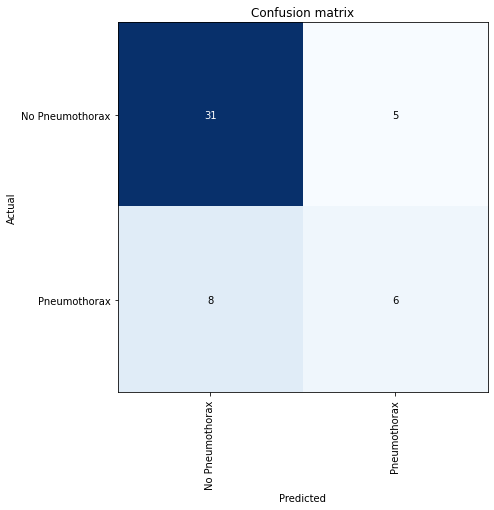

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

You can also reproduce the results interpreted from plot_confusion_matrix like so:

In [40]:
upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]
print(tn, fp, fn, tp)

31 5 8 6


**Sensitivity = True Positive/(True Positive + False Negative)**

In [41]:
specificity = tn/(fp + tn)
specificity

0.8611111111111112

In this case the model has a sensitivity of 86% and hence is only capable of correctly detecting 86% True Positives (i.e. who have Pneumothorax) but will miss 14% of False Negatives (patients that actually have Pneumothorax but were told they did not! Not a good situation to be in).

This is also know as a **Type II error**

**Specificity = True Negative/(False Positive + True Negative)**

In [42]:
sensitivity = tp/(tp + fn)
sensitivity

0.42857142857142855

The model has a specificity of 43% and hence can correctly detect 43% of the time that a patient does not have Pneumothorax but will incorrectly classify that 67% of the patients have Pneumothorax (False Postive) but actually do not.

This is also known as a **Type I error**

**Positive Predictive Value (PPV)**

In [43]:
ppv = tp/(tp+fp)
ppv

0.5454545454545454

**Negative Predictive Value (NPV)**

In [44]:
npv = tn/(tn+fn)
npv

0.7948717948717948

**Calculating Accuracy**

accuracy = sensitivity x prevalence + specificity * (1 - prevalence)

Where prevalence is a statistical concept referring to the number of cases of a disease that are present in a particular population at a given time. The prevalence in this case is how many patients in the valid dataset have the condition compared to the total number.

To view the files in the valid dataset you call `dls.valid_ds.cat`

In [45]:
val = dls.valid_ds.cat
#val[0]

In [46]:
prevalence = 14/50
prevalence

0.28

In [47]:
accuracy = (sensitivity * prevalence) + (specificity * (1 - prevalence))
accuracy

0.74

### Under the Hood - Model Interpretability

#### Generating bounding boxes from Class Activation Maps

Class Activation Maps were introduced by Bolei Zhou et al. in the paper[ Learning Deep Features for Discriminative Localization](https://arxiv.org/abs/1512.04150) and is a tool that is often using for model interpretation.

Typically you view CAMs to see what areas of the image have the highest activations.  However with `fmi` we take it a step further so that you can view the highest activations in all classes within a dataset.

- **A blog taking a deeper look at the code is coming soon!**

Load the test set

In [39]:
test_path = 'C:/Users/avird/.fastai/data/siim_small/test'
test_files = get_dicom_files(test_path)
test_files

(#2) [Path('C:/Users/avird/.fastai/data/siim_small/test/000014.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/test/000070.dcm')]

In [40]:
test_one = test_files[0]
test_two = test_files[1]

#### get_cmaps

`get_cmaps` is a handy `fmi` feature from where you can easily view activation maps

first we have to define which layer in the model you want to view.  For this case I want to view the last layer

In [92]:
layer = learn.model[0][7][-1]

`get_cmaps` allows for some flexibility:
 
- sanity = if you want to check actual values
- show_maps = display the class activation map
- show_cmap = display the test image with the class activation map super-imposed

Pneumothorax
tensor([1, 0])
tensor([0.5820, 0.4180])


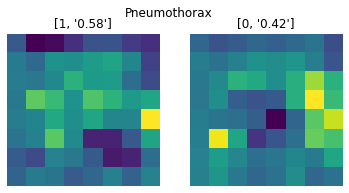

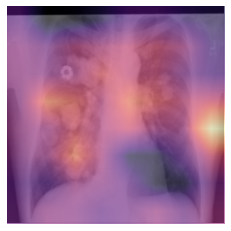

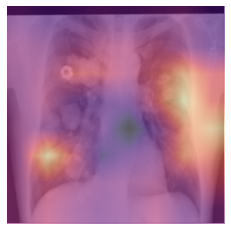

In [93]:
get_cmaps(test_one, dls, learn, layer=layer, sanity=True, show_maps=True, show_cmap=True)

`get_boxes` is another `fmi` feature where the output is a bounding box around the area of maximum activations in each class probability.

Predicted: Pneumothorax
tensor([1, 0])
Probs: tensor([0.5820, 0.4180])
Array Boxes: [array([ 896,  512, 1024,  640]), array([768, 384, 896, 512])]

1
Tensor: 0.5820483565330505
Box: [ 896  512 1024  640]

0
Tensor: 0.4179515838623047
Box: [768 384 896 512]


[array([ 896,  512, 1024,  640]), array([768, 384, 896, 512])]

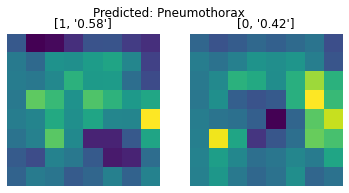

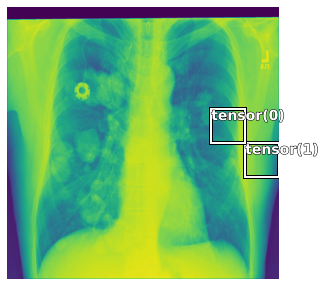

In [94]:
get_boxes(test_one, dls, learn, layer=layer, sanity=True, show_maps=True, show_img=True, color='white')

In the image above we can clearly see what areas of the image led to the models decision.  The model predicted that the image was `Pneumothorax` by a probability of `0.58` to `0.42`.  To view what is class `0` and class `1` we can:

In [95]:
dls.vocab

['No Pneumothorax', 'Pneumothorax']

Here we see that `0` is `No Pneumothorax` and `1` is `Pneumothorax`

We can now see the location of maximum activations as we go through the model layers. More needs to be researched here to see how this affects model interpretability.

In this case we will iterate through Sequential layers 4 to 7 and within each Sequential layer view the Bottleneck layers.

To view the layers use `learn.model[0]`

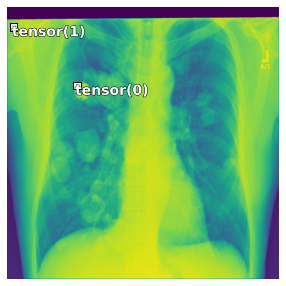

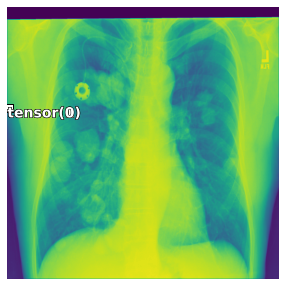

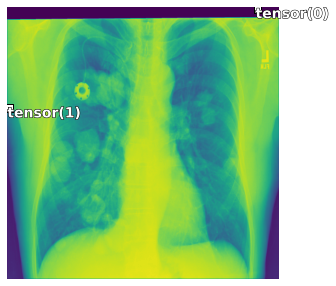

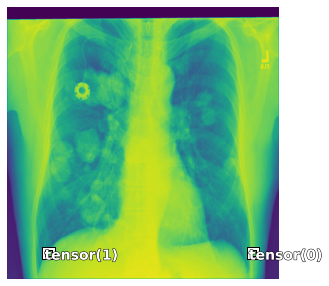

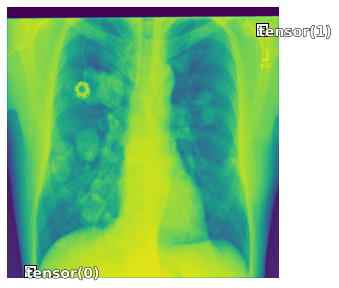

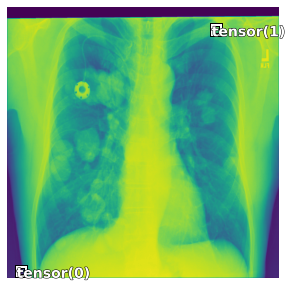

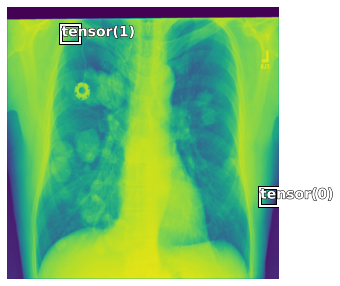

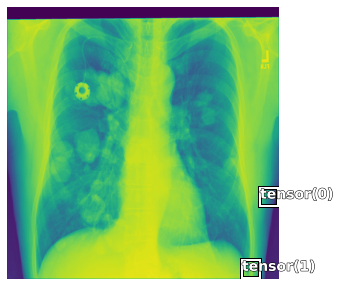

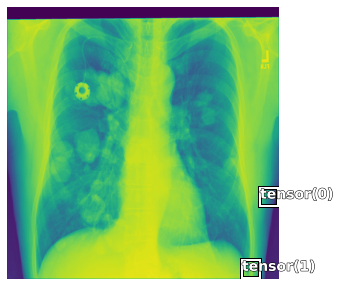

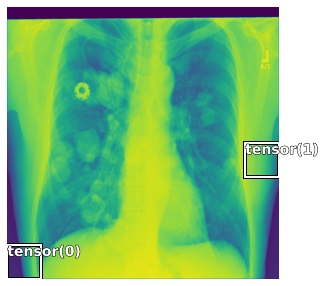

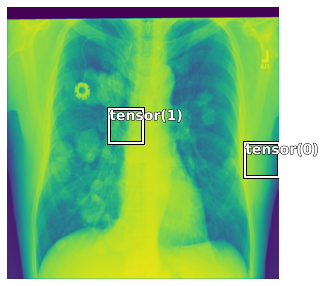

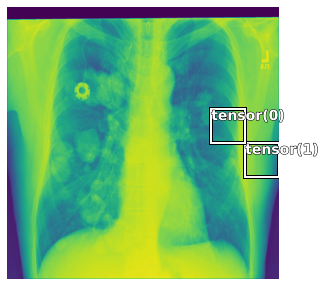

In [96]:
for i in range(4, 8):
    for j in range(0, 3):
        get_boxes(test_one, dls, learn, layer=learn.model[0][i][j], sanity = False, show_maps=False, show_img=True, color='white')

Also note that the size of the bounding boxes increase as we move down the model layers because the image size reduces

#### view_layers

`view_layers` is another feature that easily lets you view how an image transforms as we move down the model layers.  This model has 170 layers

In [41]:
layers = flatten_model(learn.model)
len(layers)

170

Viewing the first 70

c:\users\avird\anaconda3\envs\fastainew\lib\site-packages\fastai\torch_core.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

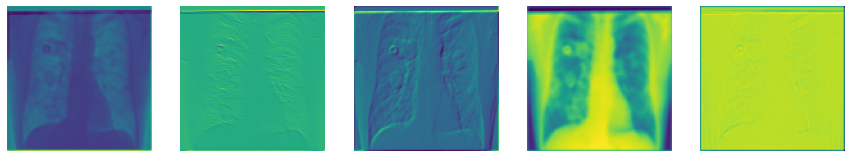

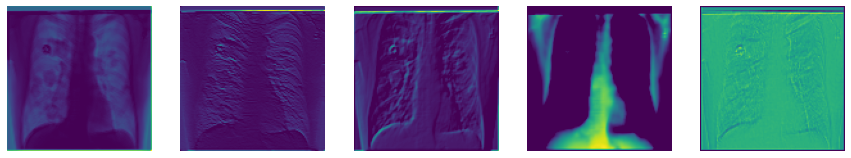

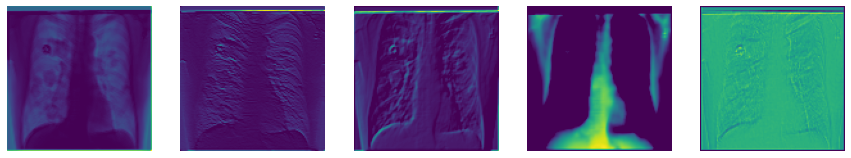

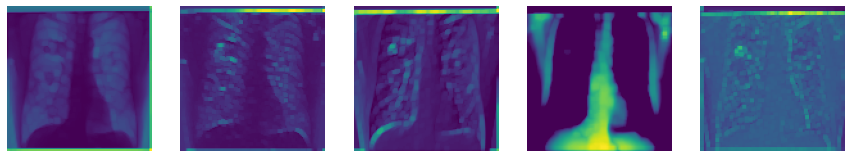

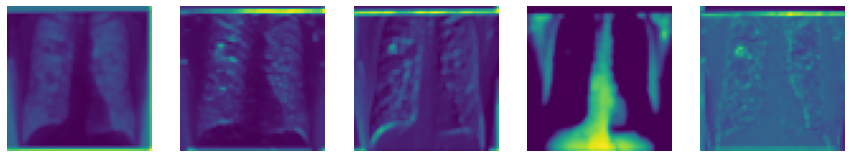

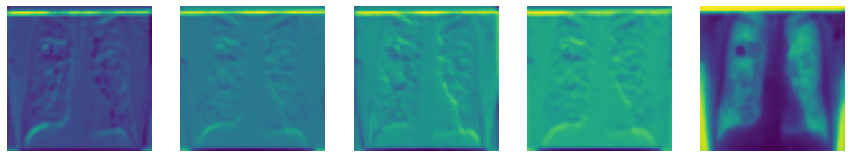

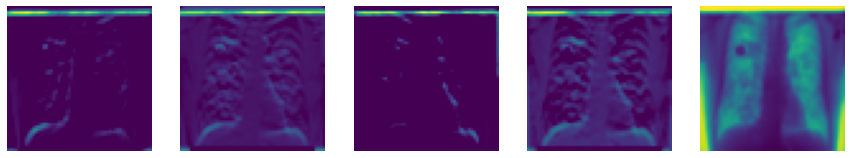

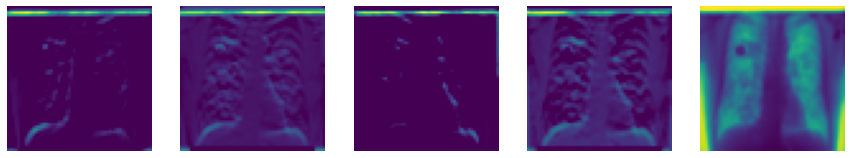

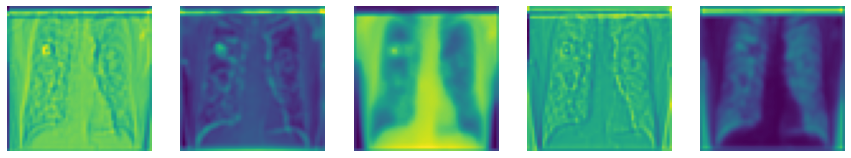

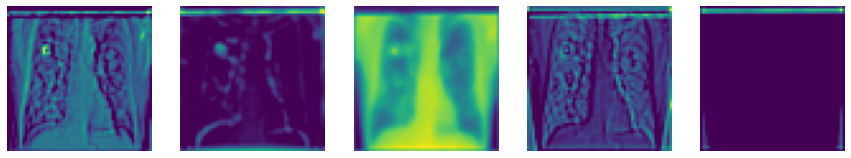

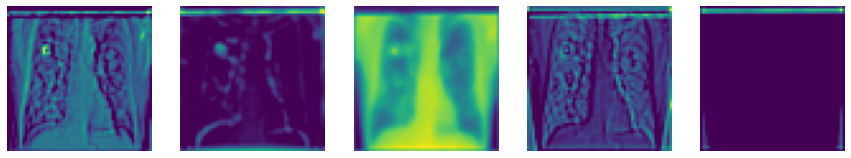

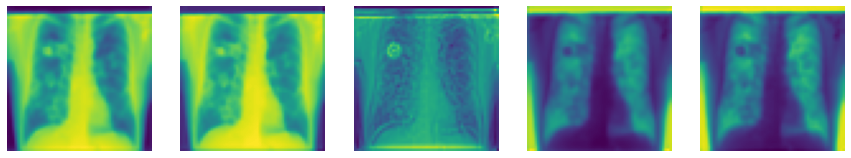

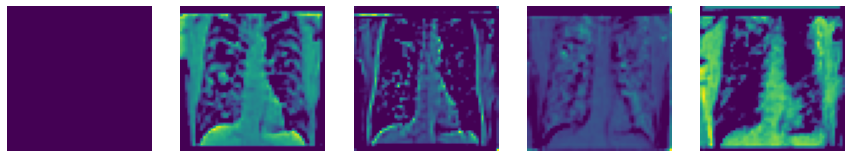

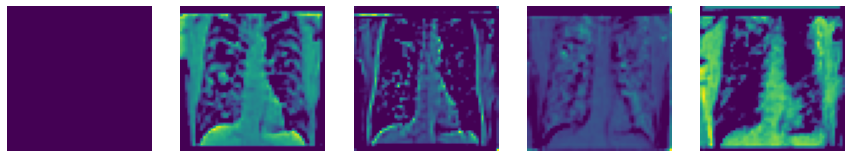

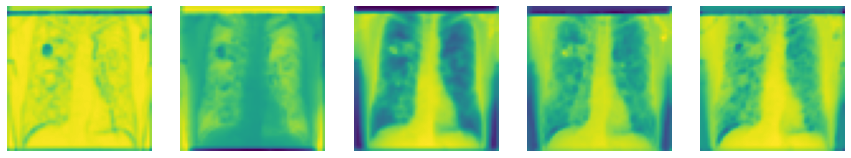

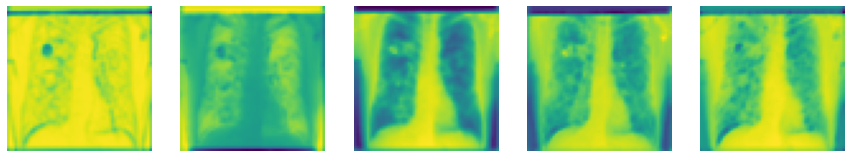

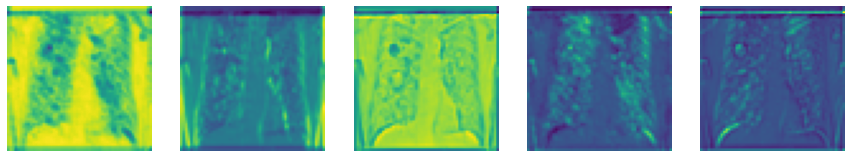

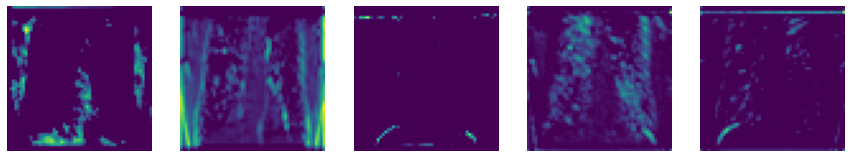

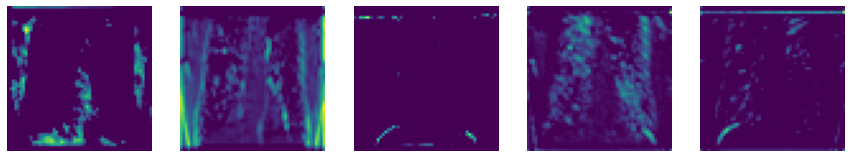

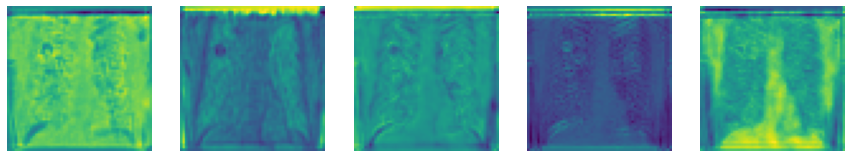

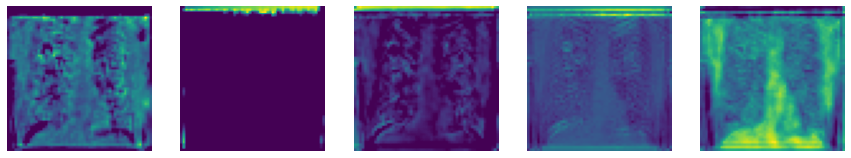

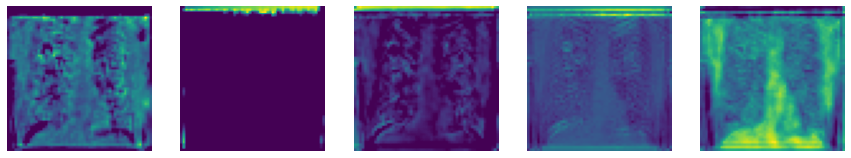

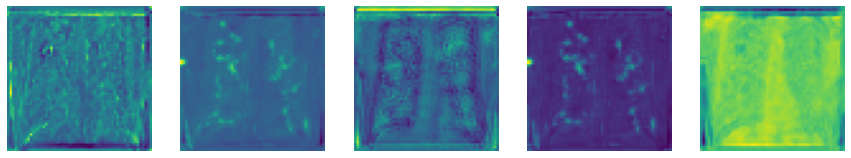

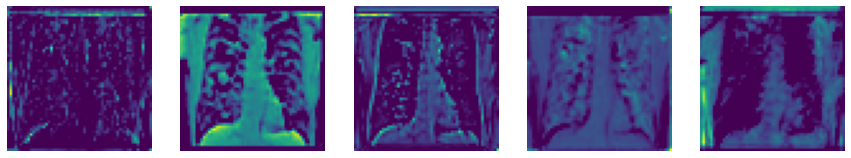

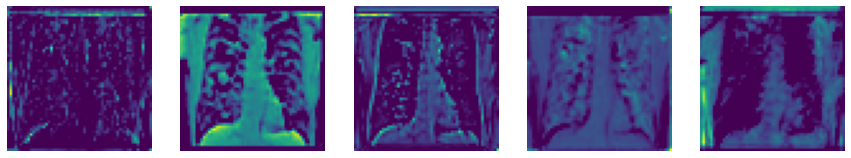

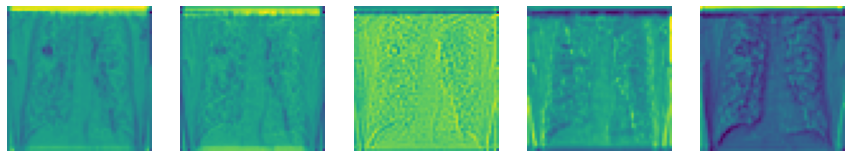

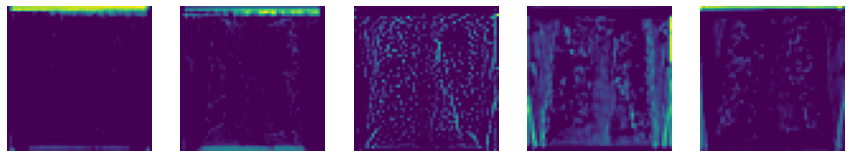

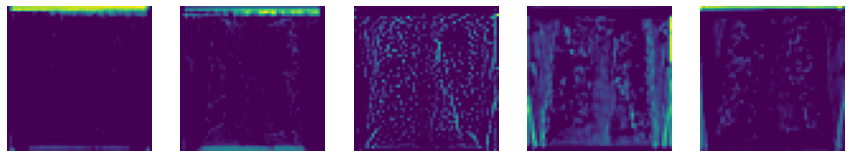

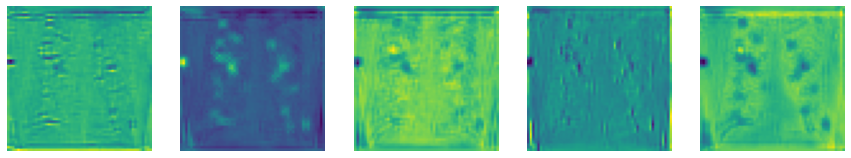

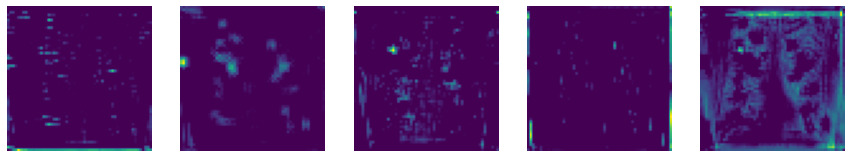

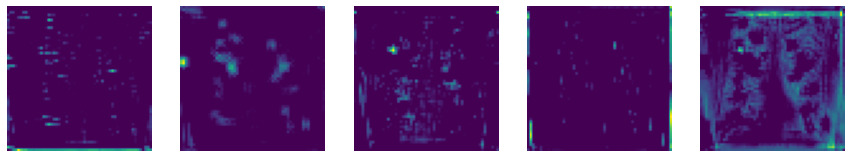

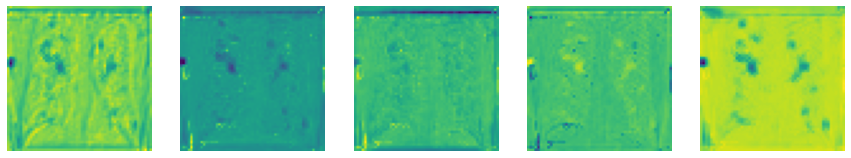

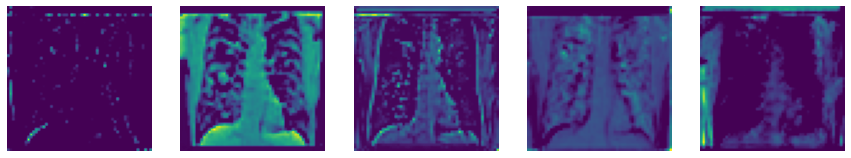

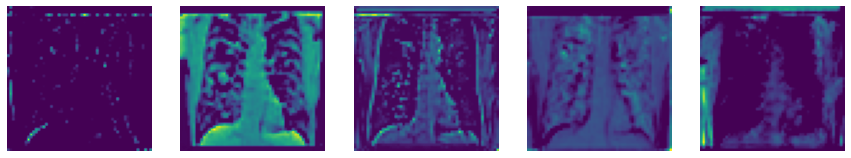

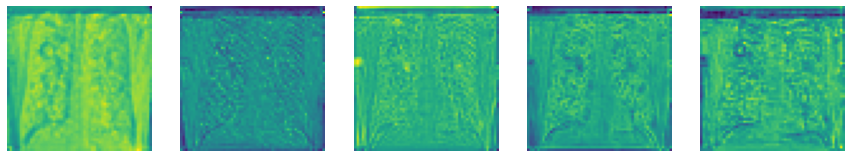

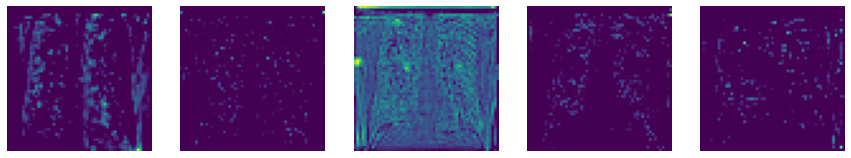

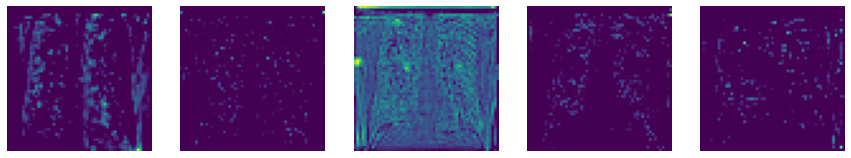

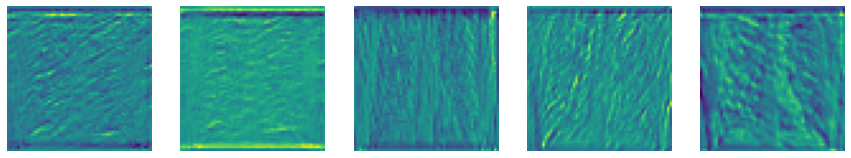

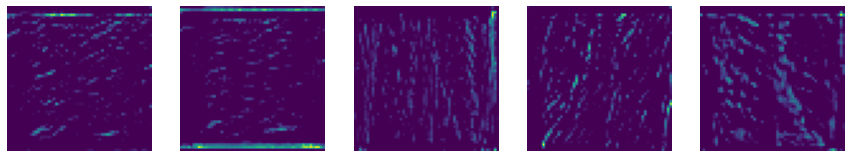

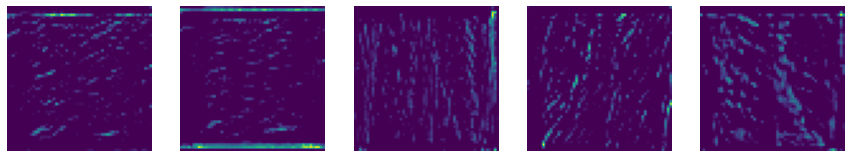

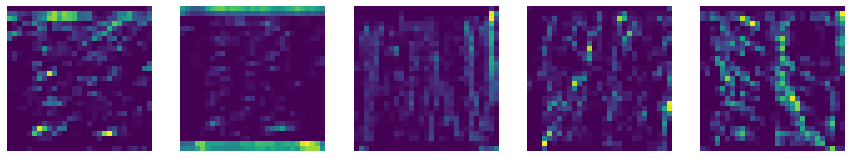

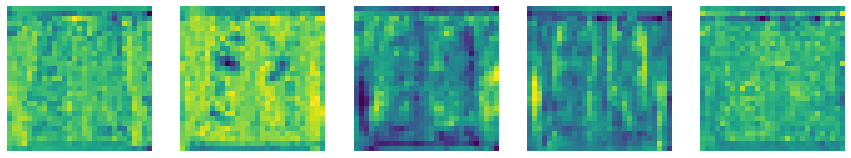

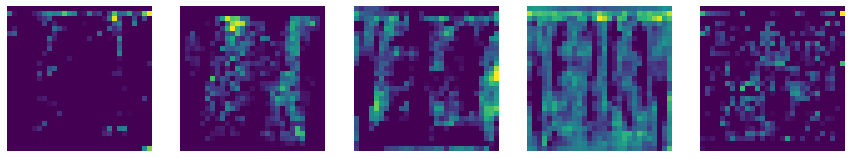

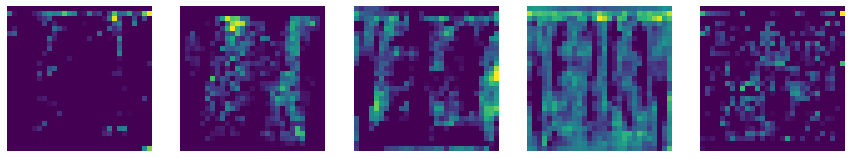

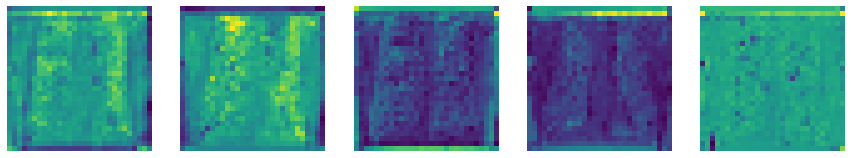

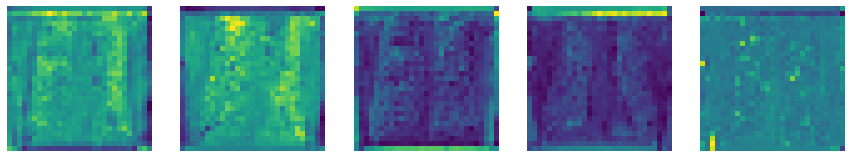

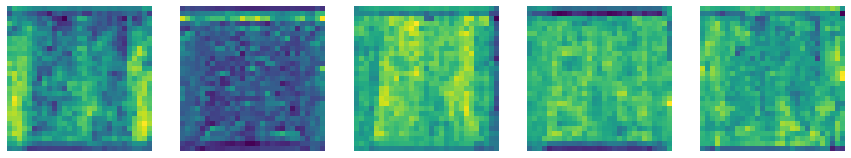

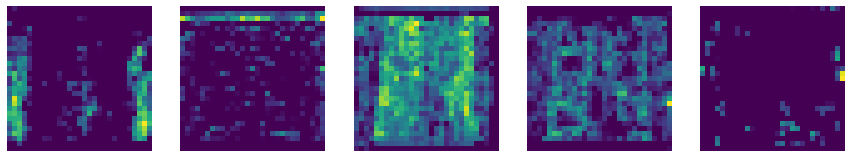

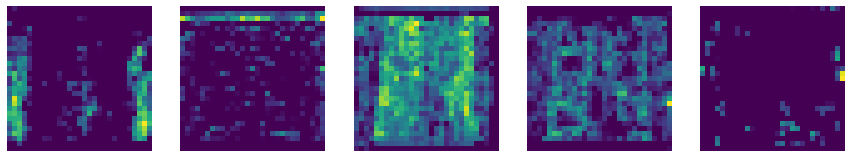

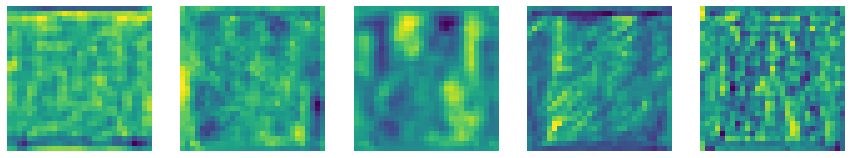

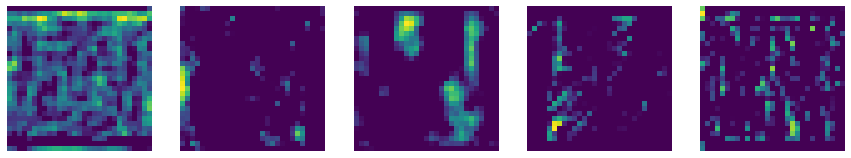

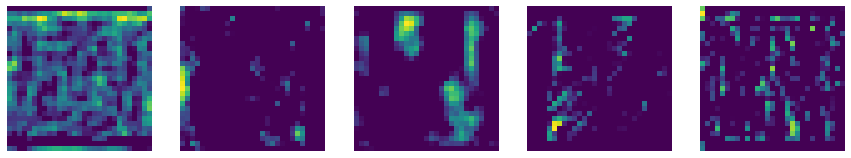

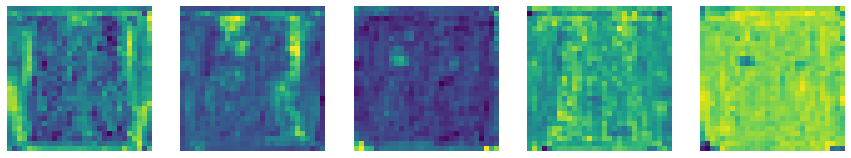

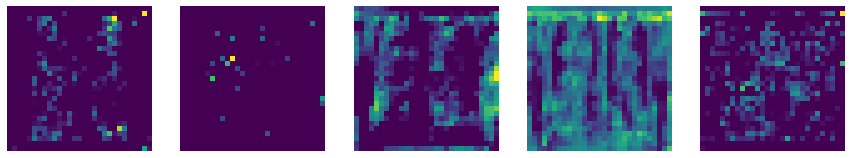

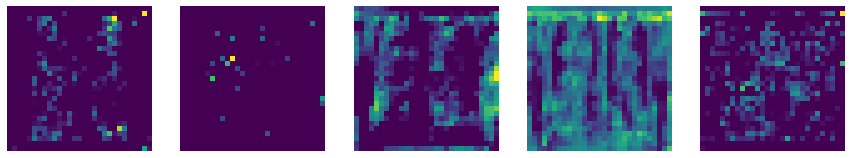

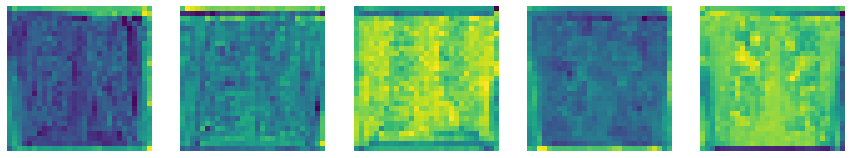

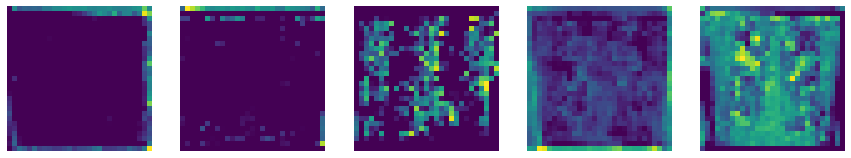

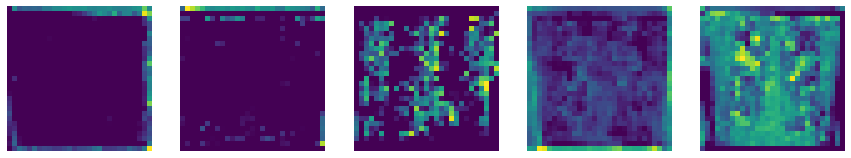

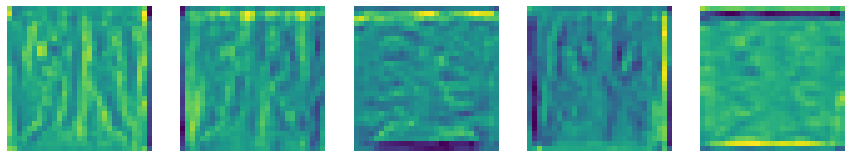

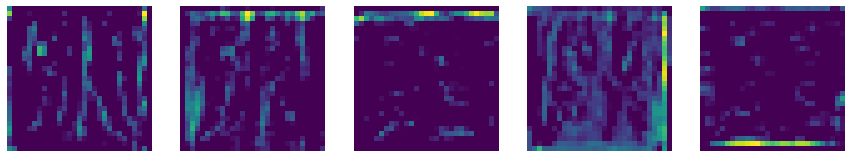

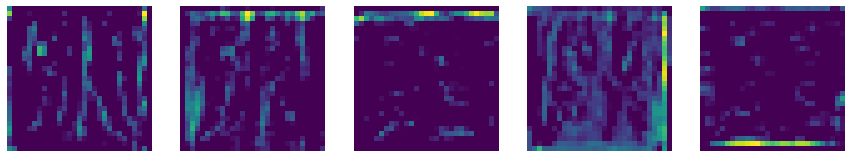

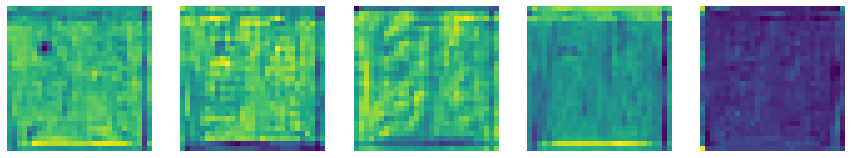

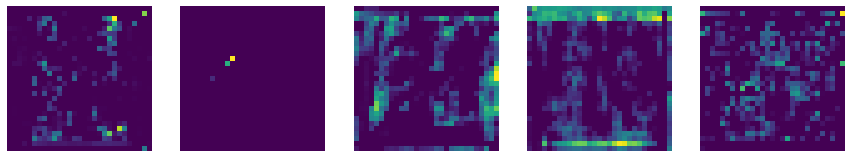

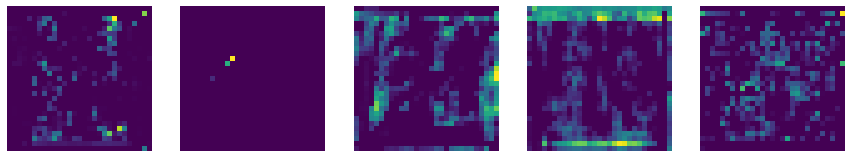

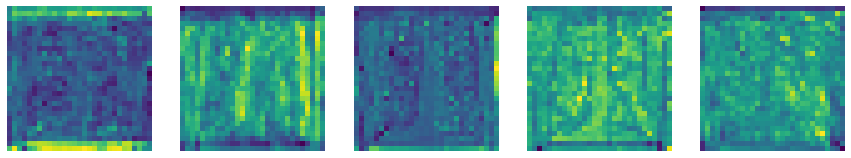

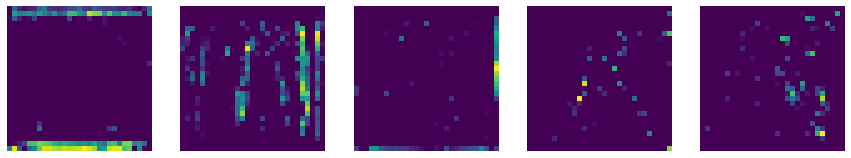

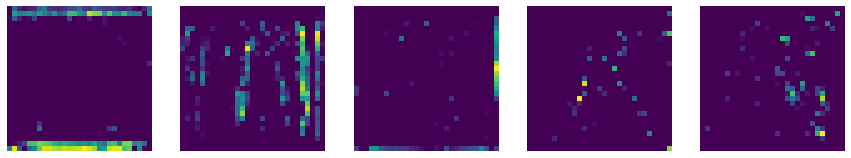

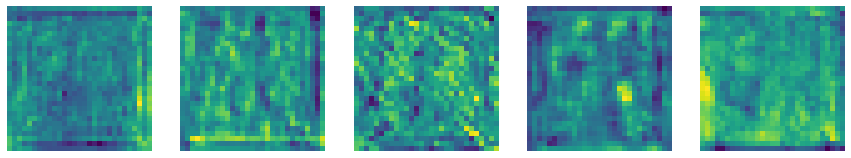

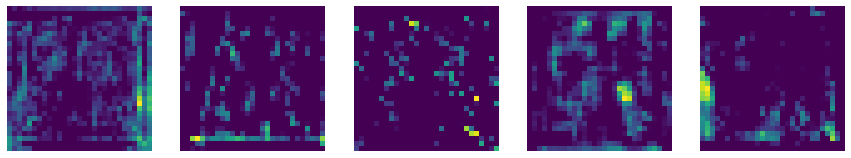

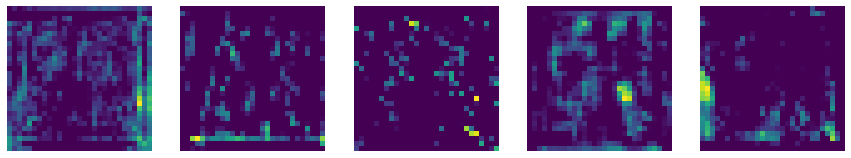

In [42]:
[view_layers(test_one, x, layers, learn, nrows=1, imgs=5, stats=False) for x in range(0,70)]